In [93]:
#Ploteo y Filtrado de señales EEG obtenidas con el Bitalino
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import firwin, lfilter
from tqdm import tqdm
from scipy import signal


#Antes de realizar el ploteo correspondiente, es necesario tener las siguientes consideraciones:

#La frecuencia de muestreo del bitalino es de 1000 Hz.
#Asimismo, la funcion de tranferencia utilizada para obtener la gráfica fue:
# (((ADC/1024)-0.5)*3.3)/41782

#-------PLOTEO DE LA SEÑAL 1
array= np.genfromtxt("/content/Reposo-EEG.txt",delimiter="	",skip_header = 2) #leemos el archivo txt

M = array[:,-2].shape[0] #longitud de la señal
valores=array[:,-2]

cantidad=np.size(valores);
#Siendo la frecuencia de muestreo del BITalino de 1000 Hz

tiempo=np.arange(0,cantidad)
tiempo=tiempo/1000

valores=(((valores/1024)-0.5)*3.3)/(41782)
valores=valores*1000000

In [94]:
#Seleccionamos solo 10 segundos de la señal para analizarla, debido a que la muestra de ojos cerrados debería ser la misma durante
#toda la toma de la señal.
# recordamos que f_muestro = 1000 Hz, por lo que en 1 segundo, tenemos 1000 muestras.
valores=valores[0:10000]
tiempo=tiempo[0:10000]

# *FILTRO IIR SEÑAL EEG*

<ipython-input-85-f35f27789799>:34: RuntimeWarning: overflow encountered in square
  band_power = np.mean(eeg_band_filtered ** 2)


Potencias de las bandas:
delta: nan
theta: inf
alpha: 4.655914038735036e+33
beta: 6.120152422183292e+27
gamma: 3.9145417881221616e+26


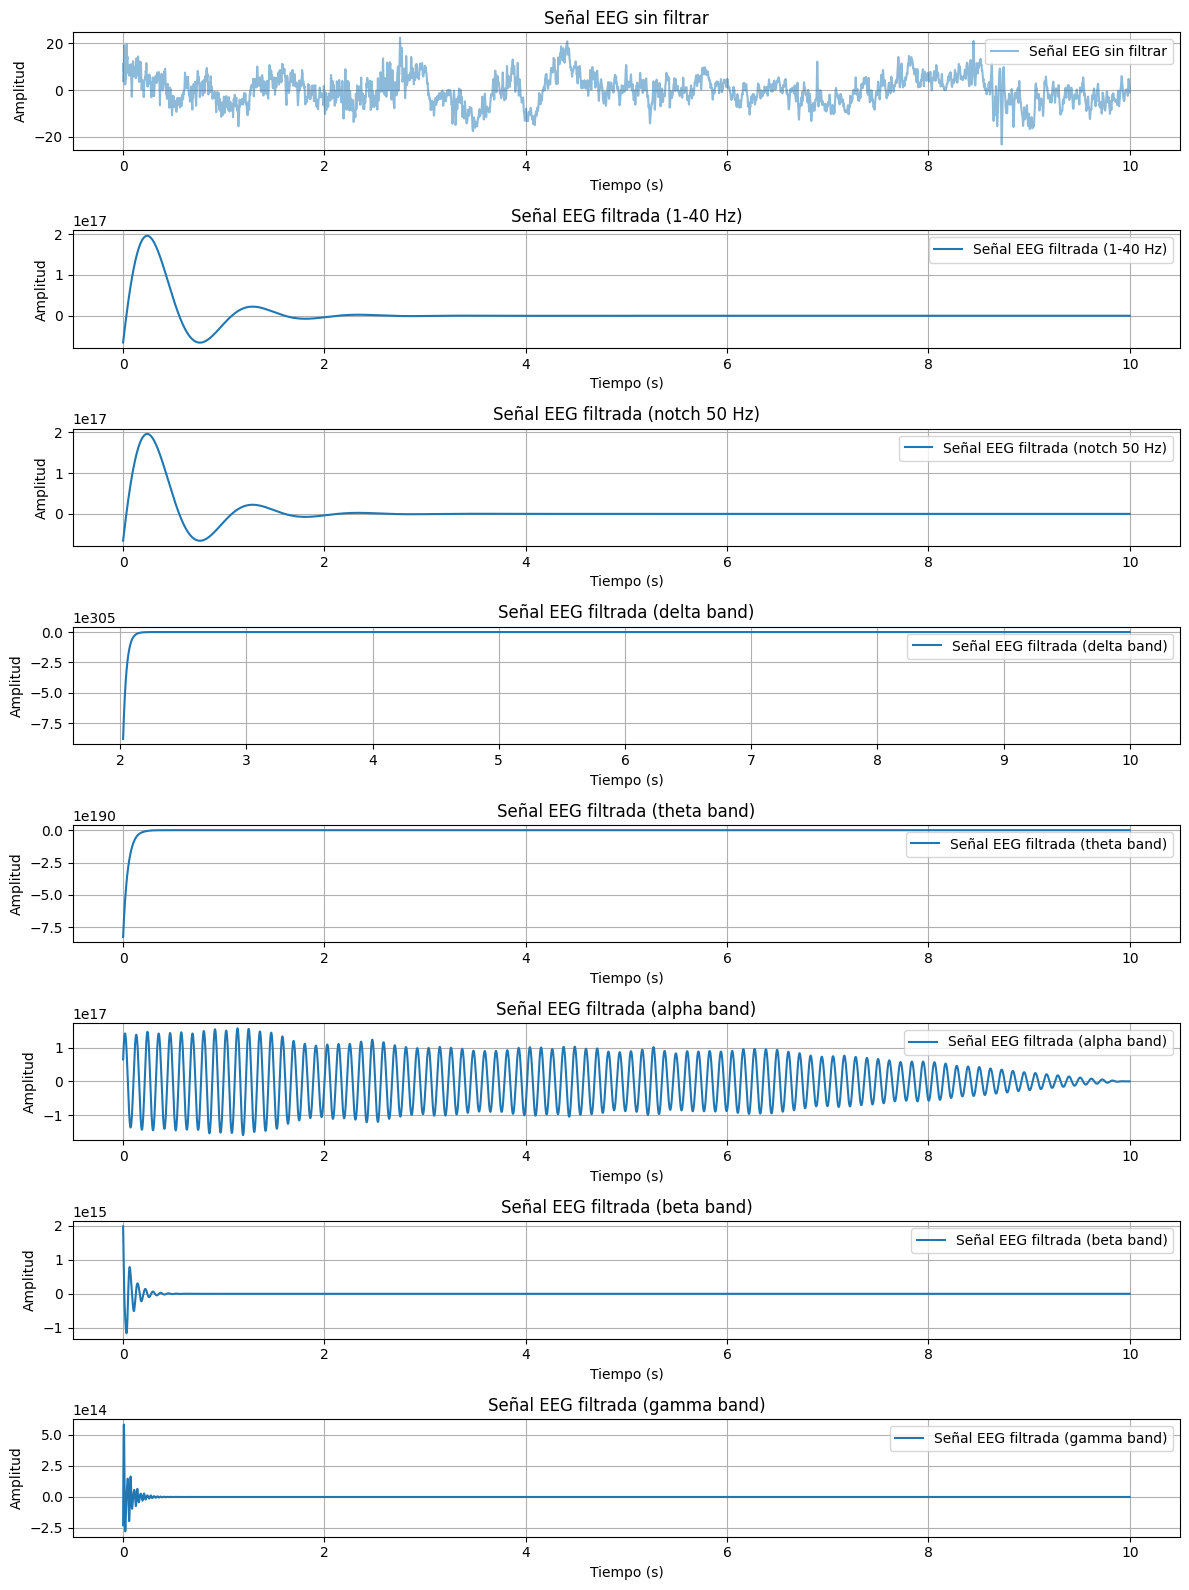

In [85]:
#Utilizamos un filtro IIR Para filtrar, estamos utilizando los valores encontrados en la literatura:
fs = 1000  # Frecuencia de muestreo
t = tiempo
eeg_data = valores

# Filtro pasa banda Butterworth de 1-40 Hz
lowcut = 1
highcut = 40
order = 5
b_bandpass, a_bandpass = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
eeg_bandpass_filtered = signal.filtfilt(b_bandpass, a_bandpass, eeg_data)

# Filtro rechaza banda (notch filter) de 50 Hz con un factor de calidad de 30
f0 = 50  # Frecuencia central del filtro notch
Q = 30   # Factor de calidad
b_notch, a_notch = signal.iirnotch(f0, Q, fs=fs)
eeg_notch_filtered = signal.filtfilt(b_notch, a_notch, eeg_bandpass_filtered)

# Subdivisión de EEG en bandas de frecuencia
bands = {'delta': (0.5, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 45)}

band_powers = {}

for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Calcular la potencia de la banda
    band_power = np.mean(eeg_band_filtered ** 2)
    band_powers[band] = band_power

# Imprimir las potencias de las bandas
print("Potencias de las bandas:")
for band, power in band_powers.items():
    print(f"{band}: {power}")

# Graficar cada señal filtrada y las bandas
plt.figure(figsize=(12, 16))

# Señal EEG sin filtrar
plt.subplot(len(bands) + 3, 1, 1)
plt.plot(t, eeg_data, label='Señal EEG sin filtrar', alpha=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG sin filtrar')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 3, 1, 2)
plt.plot(t, eeg_bandpass_filtered, label='Señal EEG filtrada (1-40 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (1-40 Hz)')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 3, 1, 3)
plt.plot(t, eeg_notch_filtered, label='Señal EEG filtrada (notch 50 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (notch 50 Hz)')
plt.legend()
plt.grid(True)

#Bandas
for i, (band, (low, high)) in enumerate(bands.items(), start=1):
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Graficar señal filtrada para la banda actual
    plt.subplot(len(bands) + 3, 1, i + 3)
    plt.plot(t, eeg_band_filtered, label=f'Señal EEG filtrada ({band} band)', linestyle='-')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Señal EEG filtrada ({band} band)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


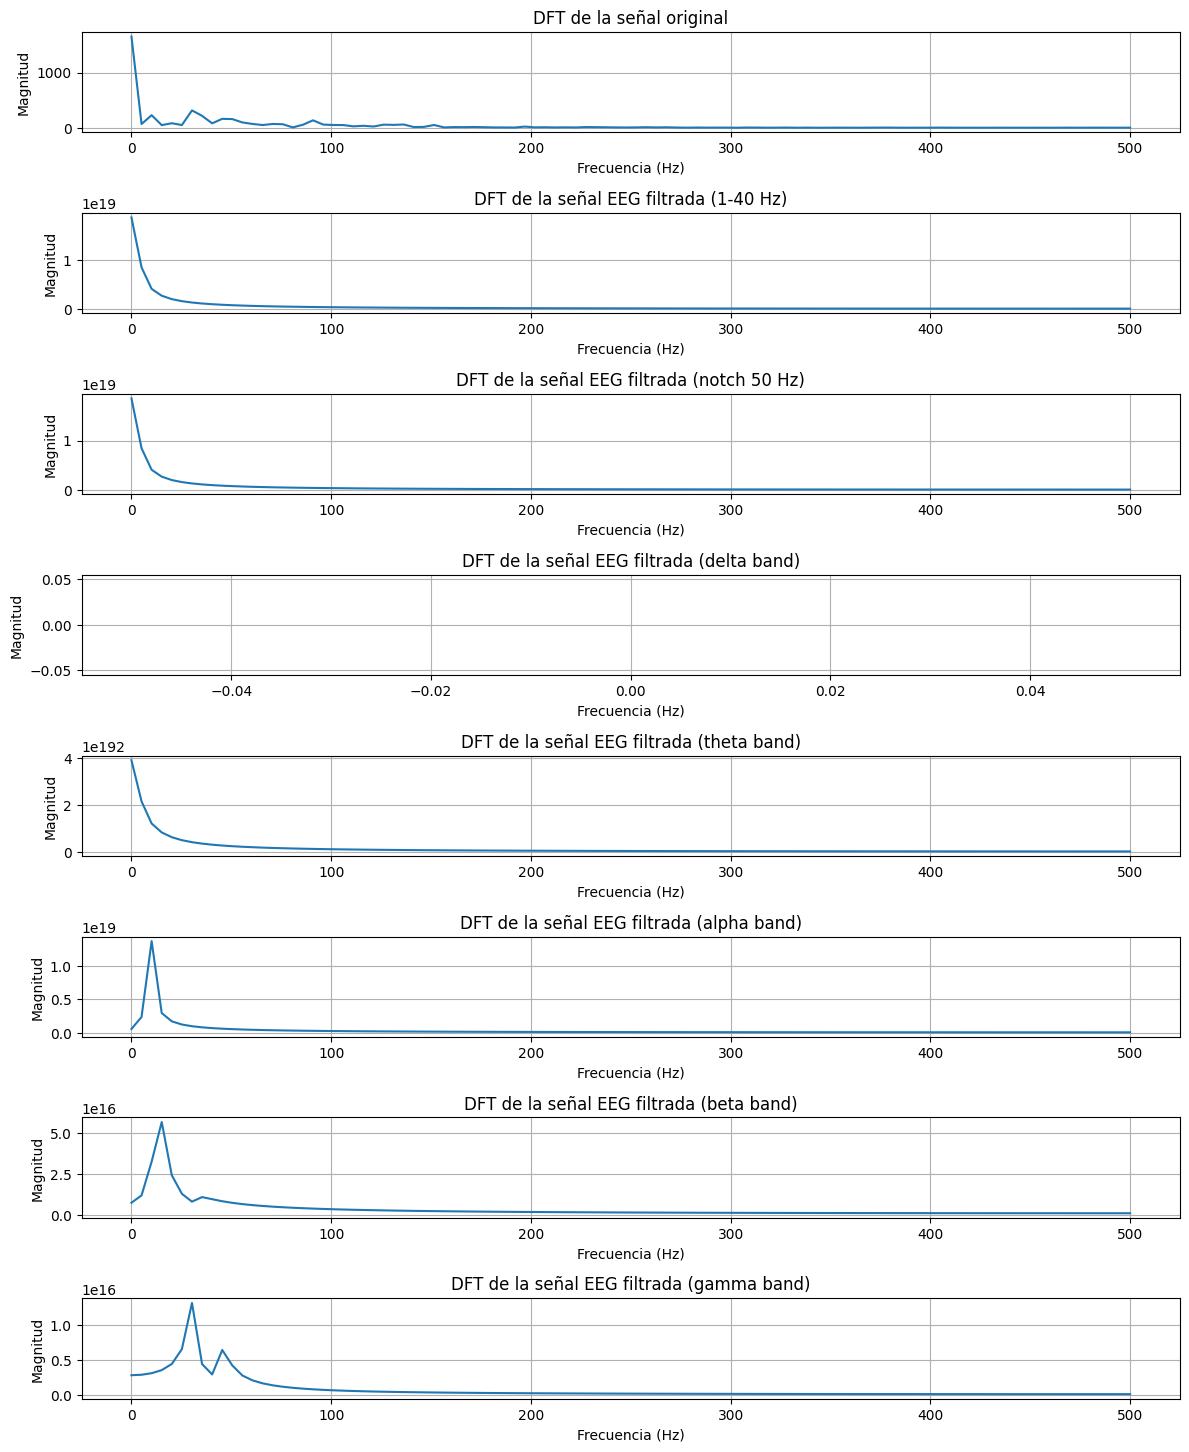

In [86]:
# Calcular la Transformada de Fourier Discreta (DFT) de la señal original
N = 200
X_original = np.fft.fft(valores, N)
X_original = X_original[:N//2]  # Considerar solo la mitad de la DFT (por simetría)
F_original = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (1-40 Hz)
X_bandpass = np.fft.fft(eeg_bandpass_filtered, N)
X_bandpass = X_bandpass[:N//2]
F_bandpass = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (notch 50 Hz)
X_notch = np.fft.fft(eeg_notch_filtered, N)
X_notch = X_notch[:N//2]
F_notch = np.linspace(0, fs/2, N//2)

# Calcular la DFT de las señales filtradas por banda
X_band_dfts = {}
for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Calcular la DFT de la señal filtrada
    X_band_dfts[band] = np.fft.fft(eeg_band_filtered, N)[:N//2]

# Graficar las DFT
plt.figure(figsize=(12, 16))

# Señal original
plt.subplot(len(bands) + 4, 1, 1)
plt.plot(F_original, np.abs(X_original))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal original')
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 4, 1, 2)
plt.plot(F_bandpass, np.abs(X_bandpass))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (1-40 Hz)')
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 4, 1, 3)
plt.plot(F_notch, np.abs(X_notch))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (notch 50 Hz)')
plt.grid(True)

# DFT de las señales filtradas por banda
for i, (band, X_band_dft) in enumerate(X_band_dfts.items(), start=1):
    plt.subplot(len(bands) + 4, 1, i + 3)
    plt.plot(F_bandpass, np.abs(X_band_dft))
    plt.ylabel('Magnitud')
    plt.xlabel('Frecuencia (Hz)')
    plt.title(f'DFT de la señal EEG filtrada ({band} band)')
    plt.grid(True)

plt.tight_layout()
plt.show()


# FILTRO FIR SEÑAL EN RESPOSO

Potencias de las bandas:
delta: 1.0200367610807618e-05
theta: 1.988042921247066e-05
alpha: 8.203361030464708e-05
beta: 0.0026335715570252292
gamma: 0.06313082660339343


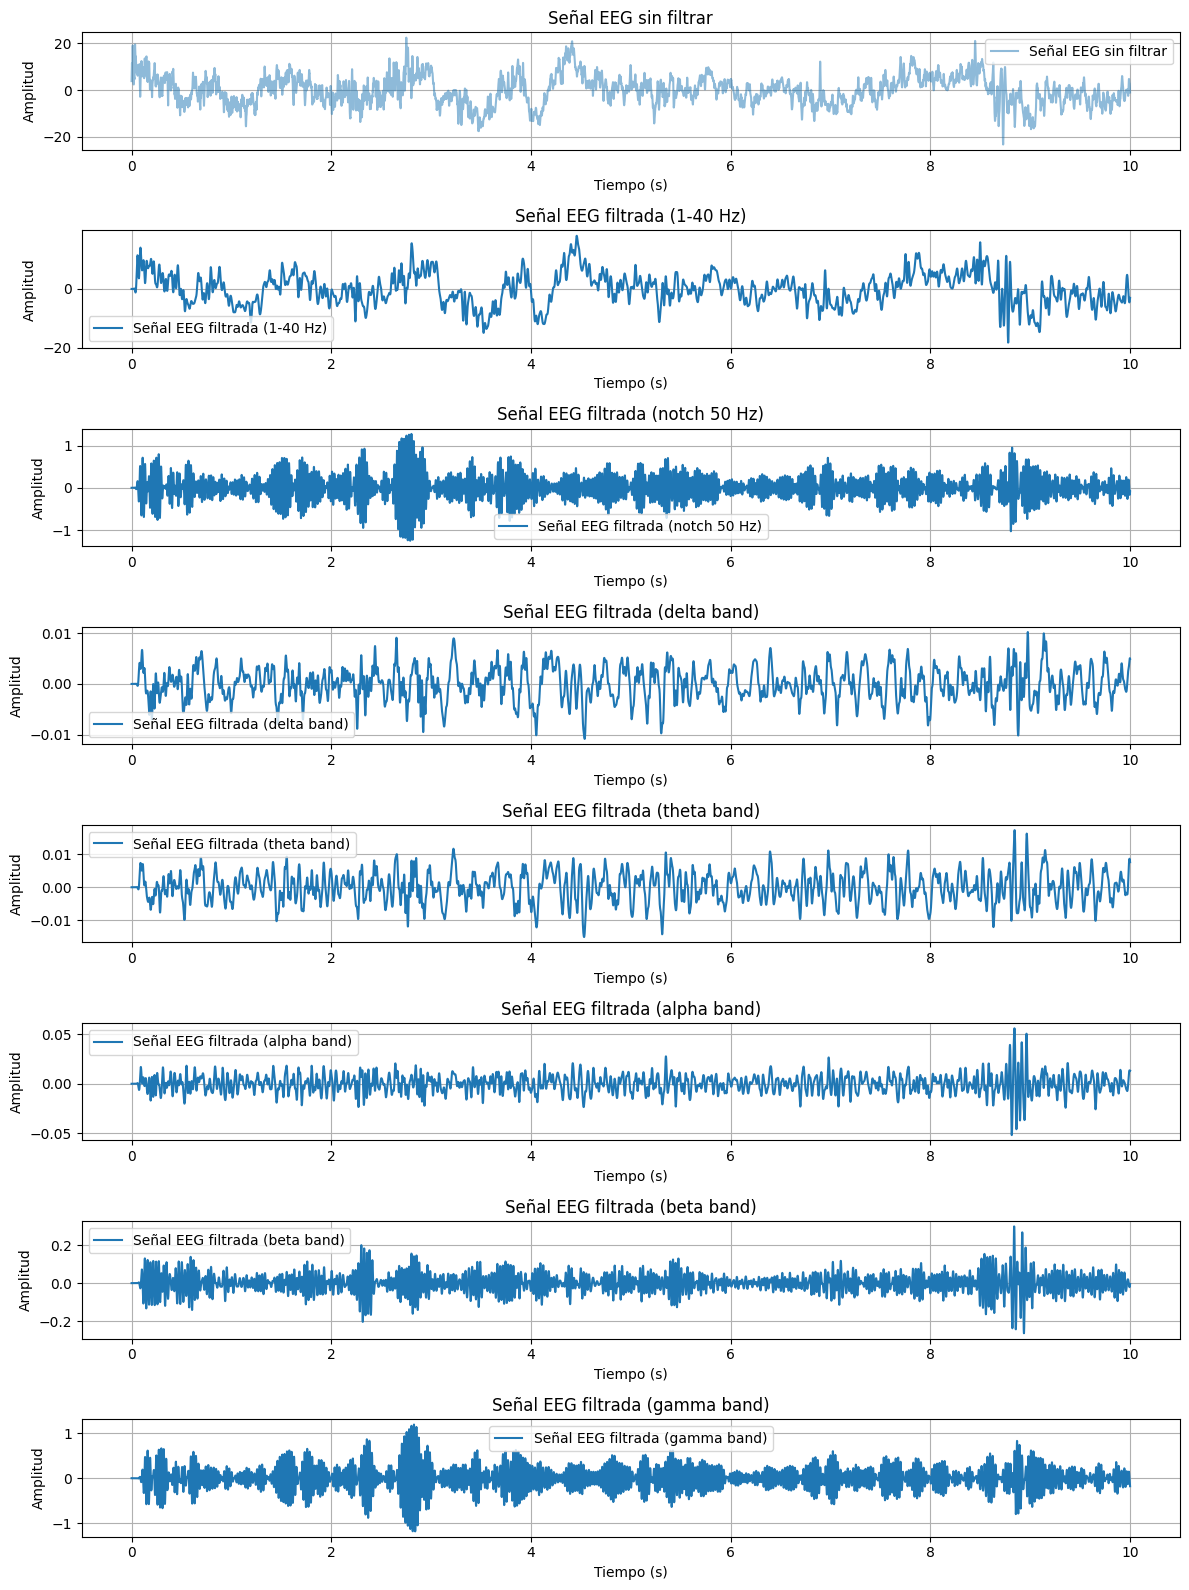

In [95]:
fs = 1000  # Frecuencia de muestreo
t = tiempo
eeg_data = valores

# Filtro pasa banda FIR de 1-40 Hz
lowcut = 1
highcut = 40
order = 100  # Longitud de la ventana FIR
b_bandpass = firwin(order + 1, [lowcut, highcut], fs=fs, pass_zero=False, window='hann')
eeg_bandpass_filtered = lfilter(b_bandpass, 1, eeg_data)

# Filtro rechaza banda FIR (notch filter) de 50 Hz
f0 = 50  # Frecuencia central del filtro notch
Q = 30   # Factor de calidad
b_notch = firwin(order + 1, [f0 - 1, f0 + 1], fs=fs, pass_zero=False, window='hann')
eeg_notch_filtered = lfilter(b_notch, 1, eeg_bandpass_filtered)

# Subdivisión de EEG en bandas de frecuencia
bands = {'delta': (0.5, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 45)}

band_powers = {}

for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda FIR para la banda actual
    b_band = firwin(order + 1, [low, high], fs=fs, pass_zero=False, window='hann')
    eeg_band_filtered = lfilter(b_band, 1, eeg_notch_filtered)

    # Calcular la potencia de la banda
    band_power = np.mean(eeg_band_filtered ** 2)
    band_powers[band] = band_power

# Imprimir las potencias de las bandas
print("Potencias de las bandas:")
for band, power in band_powers.items():
    print(f"{band}: {power}")

# Graficar cada señal filtrada y las bandas
plt.figure(figsize=(12, 16))

# Señal EEG sin filtrar
plt.subplot(len(bands) + 3, 1, 1)
plt.plot(t, eeg_data, label='Señal EEG sin filtrar', alpha=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG sin filtrar')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 3, 1, 2)
plt.plot(t, eeg_bandpass_filtered, label='Señal EEG filtrada (1-40 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (1-40 Hz)')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 3, 1, 3)
plt.plot(t, eeg_notch_filtered, label='Señal EEG filtrada (notch 50 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (notch 50 Hz)')
plt.legend()
plt.grid(True)

#Bandas
for i, (band, (low, high)) in enumerate(bands.items(), start=1):
    # Aplicar filtro pasa banda FIR para la banda actual
    b_band = firwin(order + 1, [low, high], fs=fs, pass_zero=False, window='hann')
    eeg_band_filtered = lfilter(b_band, 1, eeg_notch_filtered)

    # Graficar señal filtrada para la banda actual
    plt.subplot(len(bands) + 3, 1, i + 3)
    plt.plot(t, eeg_band_filtered, label=f'Señal EEG filtrada ({band} band)', linestyle='-')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Señal EEG filtrada ({band} band)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


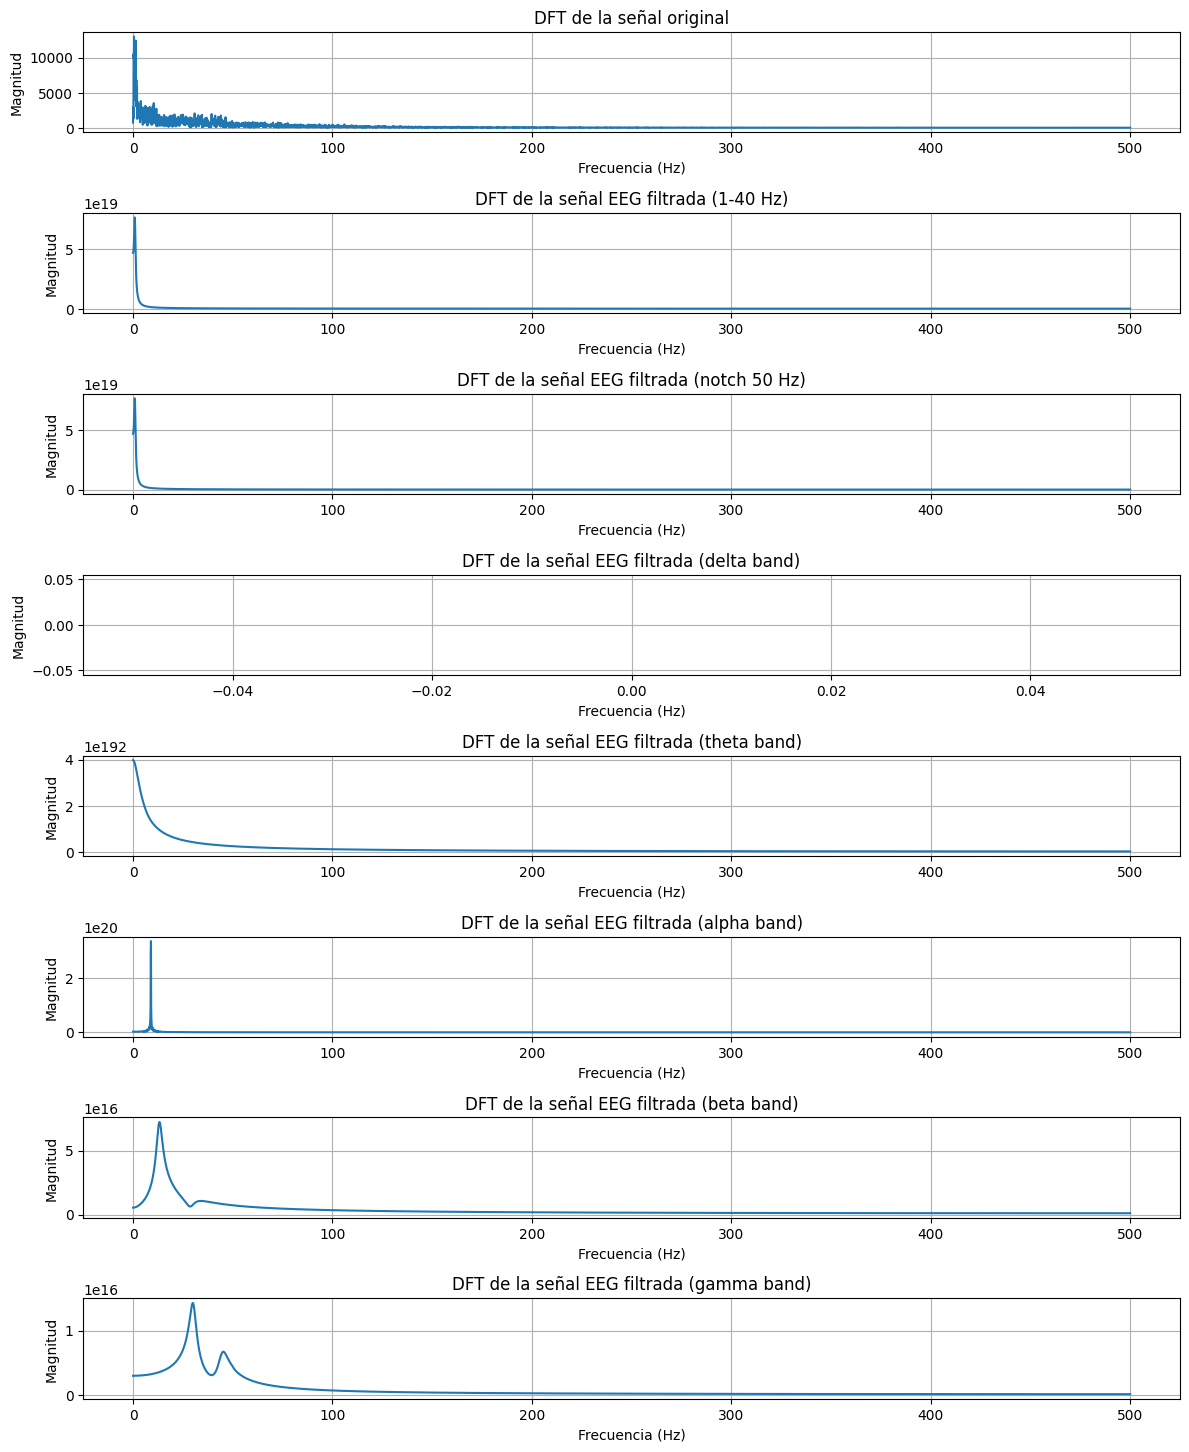

In [69]:
# Calcular la DFT de la señal original
N = len(valores)
X_original = np.fft.fft(valores, N)
X_original = X_original[:N//2]  # Considerar solo la mitad de la DFT (por simetría)
F_original = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (1-40 Hz)
X_bandpass = np.fft.fft(eeg_bandpass_filtered, N)
X_bandpass = X_bandpass[:N//2]
F_bandpass = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (notch 50 Hz)
X_notch = np.fft.fft(eeg_notch_filtered, N)
X_notch = X_notch[:N//2]
F_notch = np.linspace(0, fs/2, N//2)

# Calcular la DFT de las señales filtradas por banda
X_band_dfts = {}
for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Calcular la DFT de la señal filtrada
    X_band_dft = np.fft.fft(eeg_band_filtered, N)[:N//2]
    X_band_dfts[band] = X_band_dft

# Graficar las DFT
plt.figure(figsize=(12, 16))

# Señal original
plt.subplot(len(bands) + 4, 1, 1)
plt.plot(F_original, np.abs(X_original))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal original')
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 4, 1, 2)
plt.plot(F_original, np.abs(X_bandpass))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (1-40 Hz)')
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 4, 1, 3)
plt.plot(F_original, np.abs(X_notch))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (notch 50 Hz)')
plt.grid(True)

# DFT de las señales filtradas por banda
for i, (band, X_band_dft) in enumerate(X_band_dfts.items(), start=1):
    plt.subplot(len(bands) + 4, 1, i + 3)
    plt.plot(F_original, np.abs(X_band_dft))
    plt.ylabel('Magnitud')
    plt.xlabel('Frecuencia (Hz)')
    plt.title(f'DFT de la señal EEG filtrada ({band} band)')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [87]:
#-------PLOTEO DE LA SEÑAL 2
array = np.genfromtxt("/content/2 EEG.txt",delimiter="	",skip_header = 2) #leemos el archivo txt

M = array[:,-2].shape[0] #longitud de la señal
valores2=array[:,-2]

cantidad2=np.size(valores2);
#Siendo la frecuencia de muestreo del BITalino de 1000 Hz

tiempo2=np.arange(0,cantidad2)
tiempo2=tiempo2/1000

valores2=(((valores2/1024)-0.5)*3.3)/(41782)
valores2=valores2*1000000

valores2=valores2[0:10000]
tiempo2=tiempo2[0:10000]


# FILTRO IIR CICLO DE OJOS ABIERTOS Y *CERRADOS*

<ipython-input-88-511057d21934>:34: RuntimeWarning: overflow encountered in square
  band_power = np.mean(eeg_band_filtered ** 2)


Potencias de las bandas:
delta: nan
theta: inf
alpha: 4.4677191637269175e+34
beta: 1.5151277688314806e+28
gamma: 9.443488179693834e+26


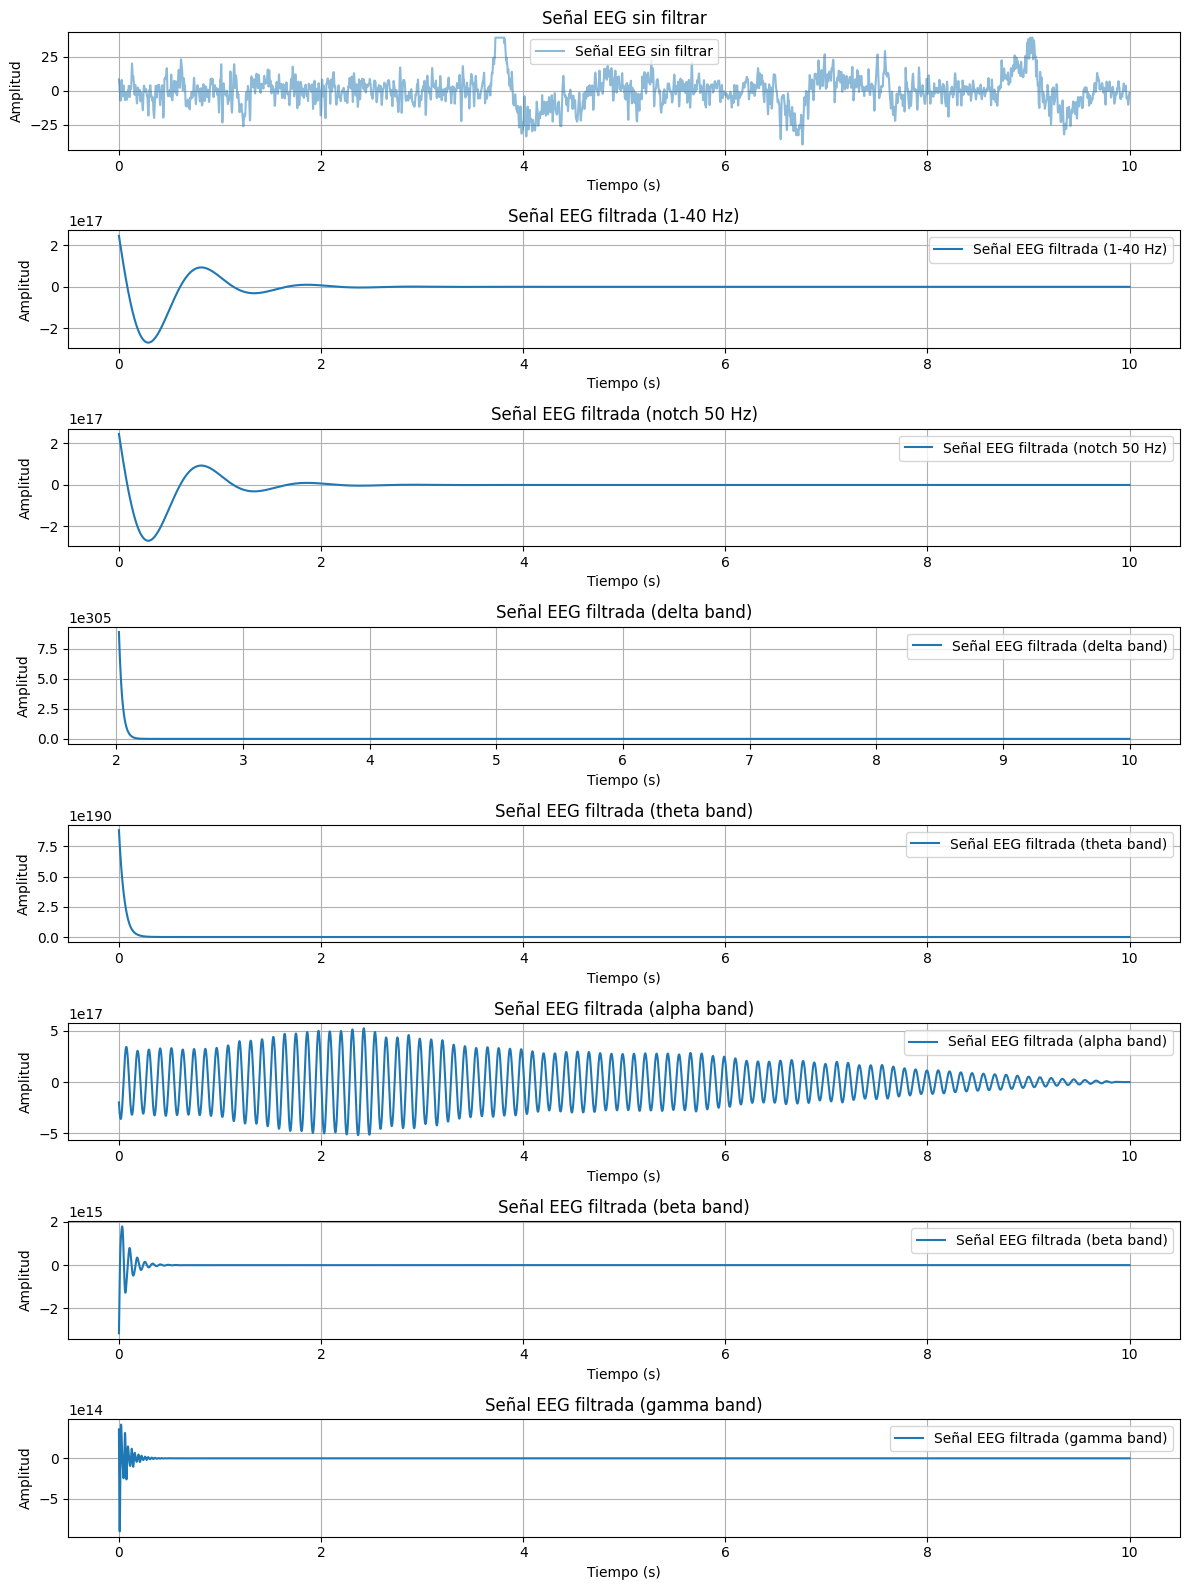

In [88]:
#Utilizamos un filtro IIR Para filtrar, estamos utilizando los valores encontrados en la literatura:
fs = 1000  # Frecuencia de muestreo
t = tiempo2
eeg_data = valores2

# Filtro pasa banda Butterworth de 1-40 Hz
lowcut = 1
highcut = 40
order = 5
b_bandpass, a_bandpass = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
eeg_bandpass_filtered = signal.filtfilt(b_bandpass, a_bandpass, eeg_data)

# Filtro rechaza banda (notch filter) de 50 Hz con un factor de calidad de 30
f0 = 50  # Frecuencia central del filtro notch
Q = 30   # Factor de calidad
b_notch, a_notch = signal.iirnotch(f0, Q, fs=fs)
eeg_notch_filtered = signal.filtfilt(b_notch, a_notch, eeg_bandpass_filtered)

# Subdivisión de EEG en bandas de frecuencia
bands = {'delta': (0.5, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 45)}

band_powers = {}

for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Calcular la potencia de la banda
    band_power = np.mean(eeg_band_filtered ** 2)
    band_powers[band] = band_power

# Imprimir las potencias de las bandas
print("Potencias de las bandas:")
for band, power in band_powers.items():
    print(f"{band}: {power}")

# Graficar cada señal filtrada y las bandas
plt.figure(figsize=(12, 16))

# Señal EEG sin filtrar
plt.subplot(len(bands) + 3, 1, 1)
plt.plot(t, eeg_data, label='Señal EEG sin filtrar', alpha=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG sin filtrar')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 3, 1, 2)
plt.plot(t, eeg_bandpass_filtered, label='Señal EEG filtrada (1-40 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (1-40 Hz)')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 3, 1, 3)
plt.plot(t, eeg_notch_filtered, label='Señal EEG filtrada (notch 50 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (notch 50 Hz)')
plt.legend()
plt.grid(True)

#Bandas
for i, (band, (low, high)) in enumerate(bands.items(), start=1):
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Graficar señal filtrada para la banda actual
    plt.subplot(len(bands) + 3, 1, i + 3)
    plt.plot(t, eeg_band_filtered, label=f'Señal EEG filtrada ({band} band)', linestyle='-')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Señal EEG filtrada ({band} band)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


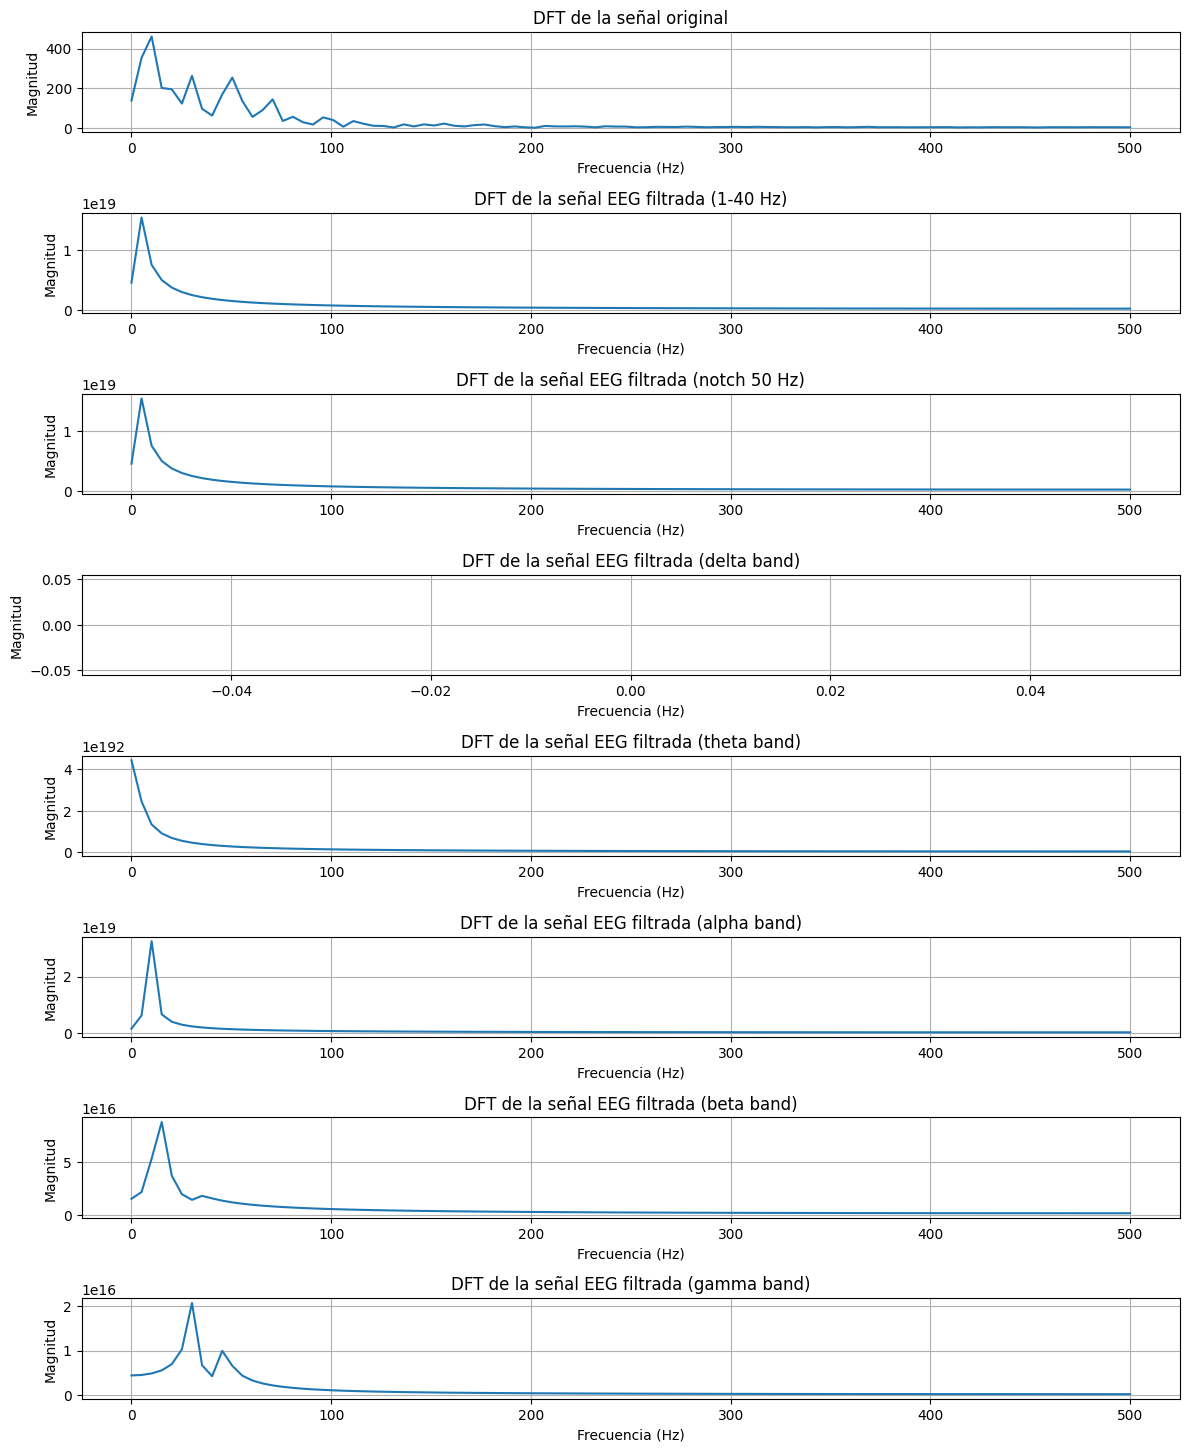

In [89]:
# Calcular la Transformada de Fourier Discreta (DFT) de la señal original
N = 200
X_original = np.fft.fft(valores2, N)
X_original = X_original[:N//2]  # Considerar solo la mitad de la DFT (por simetría)
F_original = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (1-40 Hz)
X_bandpass = np.fft.fft(eeg_bandpass_filtered, N)
X_bandpass = X_bandpass[:N//2]
F_bandpass = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (notch 50 Hz)
X_notch = np.fft.fft(eeg_notch_filtered, N)
X_notch = X_notch[:N//2]
F_notch = np.linspace(0, fs/2, N//2)

# Calcular la DFT de las señales filtradas por banda
X_band_dfts = {}
for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Calcular la DFT de la señal filtrada
    X_band_dfts[band] = np.fft.fft(eeg_band_filtered, N)[:N//2]

# Graficar las DFT
plt.figure(figsize=(12, 16))

# Señal original
plt.subplot(len(bands) + 4, 1, 1)
plt.plot(F_original, np.abs(X_original))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal original')
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 4, 1, 2)
plt.plot(F_bandpass, np.abs(X_bandpass))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (1-40 Hz)')
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 4, 1, 3)
plt.plot(F_notch, np.abs(X_notch))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (notch 50 Hz)')
plt.grid(True)

# DFT de las señales filtradas por banda
for i, (band, X_band_dft) in enumerate(X_band_dfts.items(), start=1):
    plt.subplot(len(bands) + 4, 1, i + 3)
    plt.plot(F_bandpass, np.abs(X_band_dft))
    plt.ylabel('Magnitud')
    plt.xlabel('Frecuencia (Hz)')
    plt.title(f'DFT de la señal EEG filtrada ({band} band)')
    plt.grid(True)

plt.tight_layout()
plt.show()


# FILTRO FIR CICLO DE OJOS ABIERTOS Y CERRADOS

Potencias de las bandas:
delta: 3.615367787870874e-05
theta: 7.303416980996007e-05
alpha: 0.00032108886074078147
beta: 0.009977566910790102
gamma: 0.2199042511565963


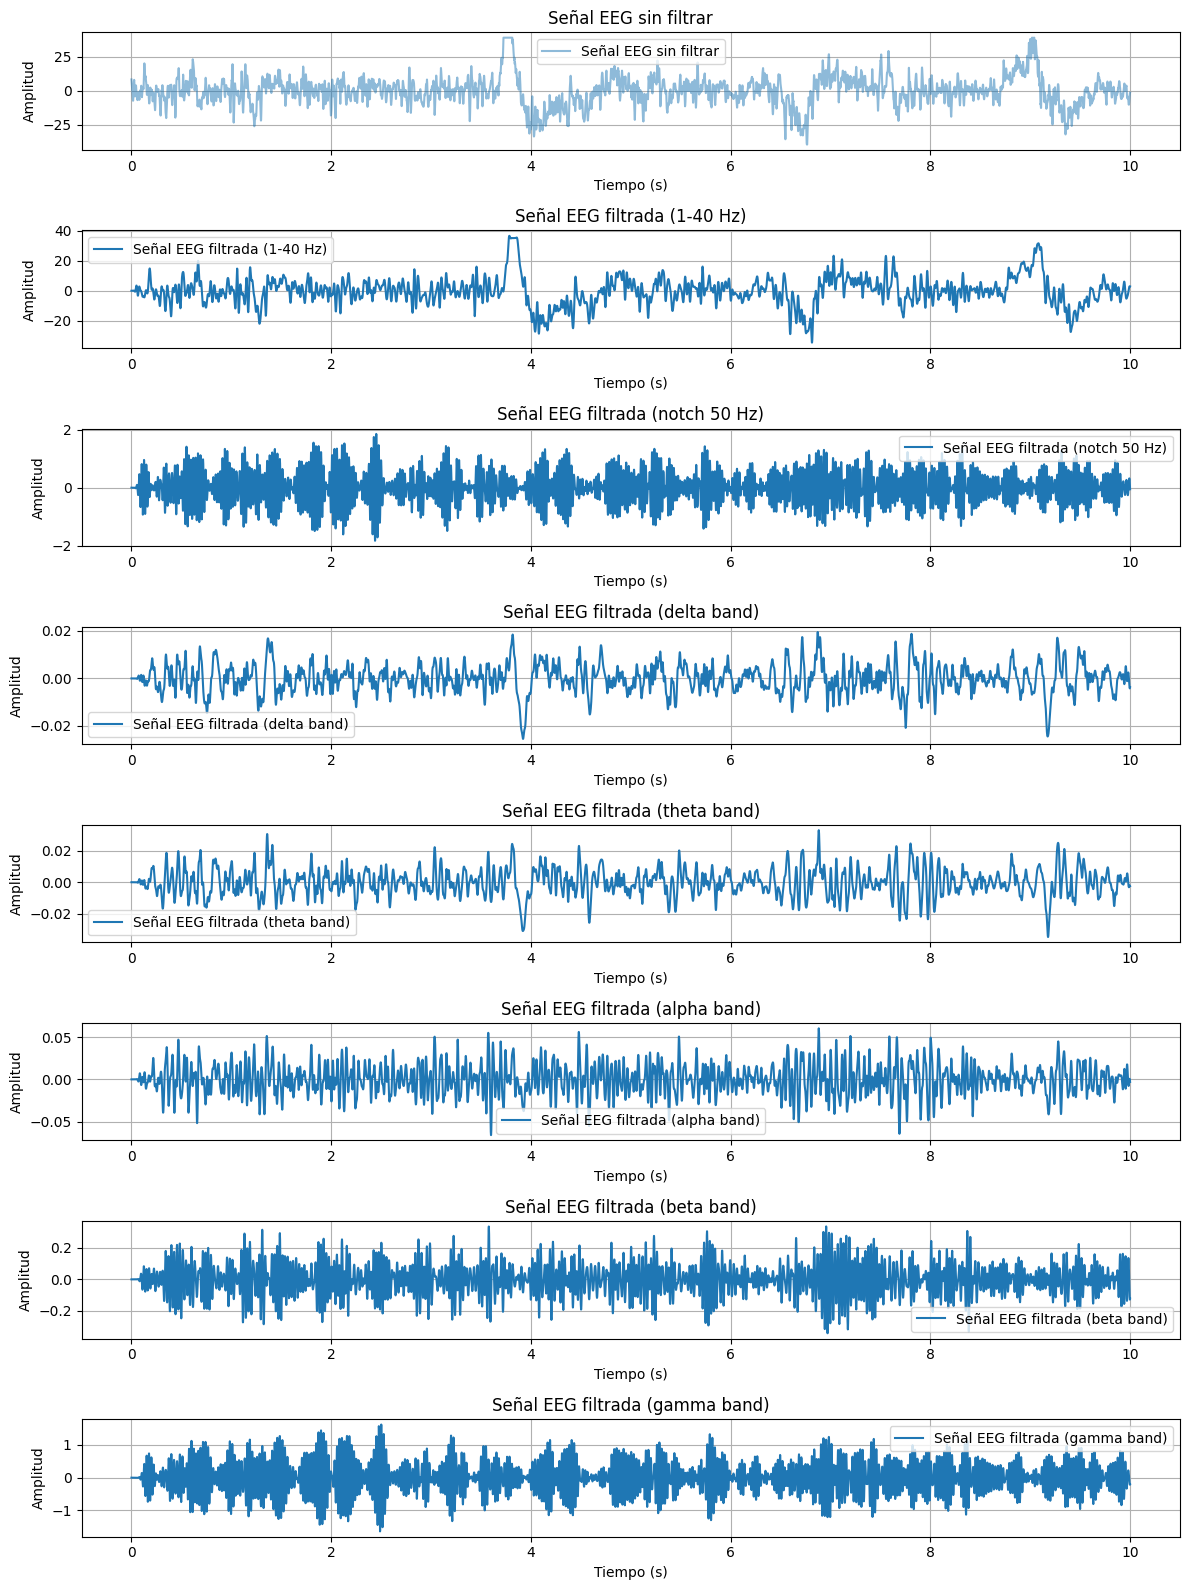

In [73]:
fs = 1000  # Frecuencia de muestreo
t = tiempo2
eeg_data = valores2

# Filtro pasa banda FIR de 1-40 Hz
lowcut = 1
highcut = 40
order = 100  # Longitud de la ventana FIR
b_bandpass = firwin(order + 1, [lowcut, highcut], fs=fs, pass_zero=False, window='hann')
eeg_bandpass_filtered = lfilter(b_bandpass, 1, eeg_data)

# Filtro rechaza banda FIR (notch filter) de 50 Hz
f0 = 50  # Frecuencia central del filtro notch
Q = 30   # Factor de calidad
b_notch = firwin(order + 1, [f0 - 1, f0 + 1], fs=fs, pass_zero=False, window='hann')
eeg_notch_filtered = lfilter(b_notch, 1, eeg_bandpass_filtered)

# Subdivisión de EEG en bandas de frecuencia
bands = {'delta': (0.5, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 45)}

band_powers = {}

for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda FIR para la banda actual
    b_band = firwin(order + 1, [low, high], fs=fs, pass_zero=False, window='hann')
    eeg_band_filtered = lfilter(b_band, 1, eeg_notch_filtered)

    # Calcular la potencia de la banda
    band_power = np.mean(eeg_band_filtered ** 2)
    band_powers[band] = band_power

# Imprimir las potencias de las bandas
print("Potencias de las bandas:")
for band, power in band_powers.items():
    print(f"{band}: {power}")

# Graficar cada señal filtrada y las bandas
plt.figure(figsize=(12, 16))

# Señal EEG sin filtrar
plt.subplot(len(bands) + 3, 1, 1)
plt.plot(t, eeg_data, label='Señal EEG sin filtrar', alpha=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG sin filtrar')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 3, 1, 2)
plt.plot(t, eeg_bandpass_filtered, label='Señal EEG filtrada (1-40 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (1-40 Hz)')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 3, 1, 3)
plt.plot(t, eeg_notch_filtered, label='Señal EEG filtrada (notch 50 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (notch 50 Hz)')
plt.legend()
plt.grid(True)

#Bandas
for i, (band, (low, high)) in enumerate(bands.items(), start=1):
    # Aplicar filtro pasa banda FIR para la banda actual
    b_band = firwin(order + 1, [low, high], fs=fs, pass_zero=False, window='hann')
    eeg_band_filtered = lfilter(b_band, 1, eeg_notch_filtered)

    # Graficar señal filtrada para la banda actual
    plt.subplot(len(bands) + 3, 1, i + 3)
    plt.plot(t, eeg_band_filtered, label=f'Señal EEG filtrada ({band} band)', linestyle='-')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Señal EEG filtrada ({band} band)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()



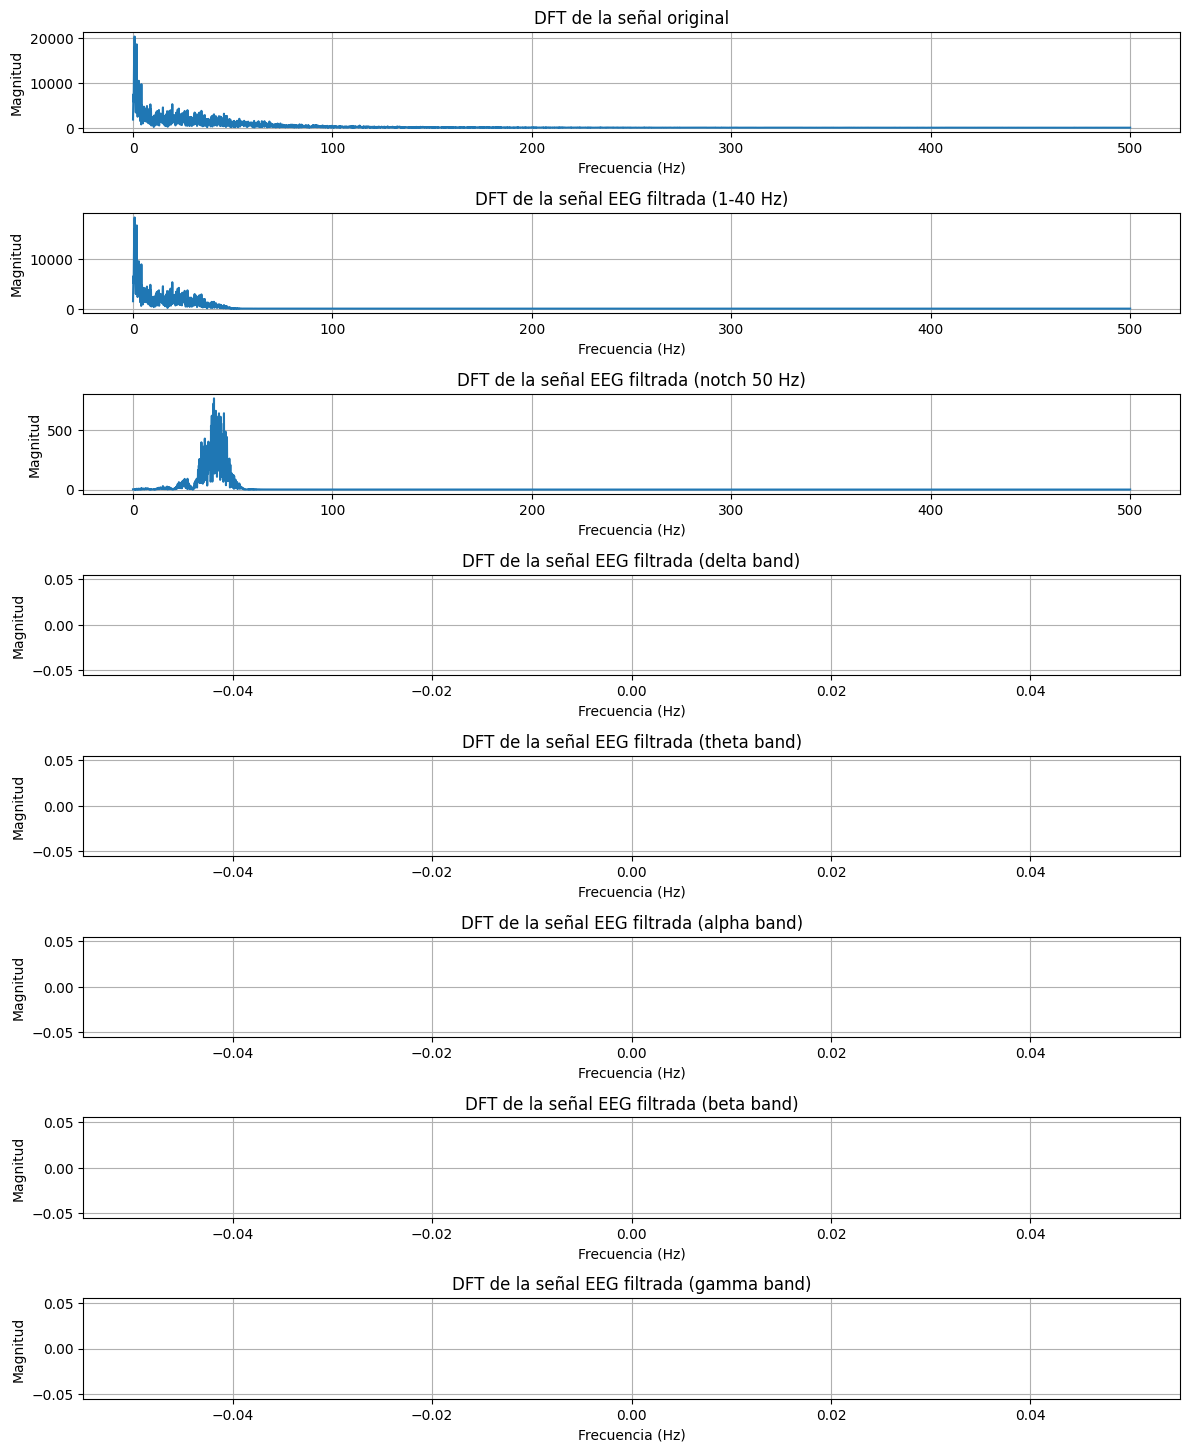

In [76]:
# Calcular la DFT de la señal original
N = 200
X_original = np.fft.fft(valores2, N)
X_original = X_original[:N//2]  # Considerar solo la mitad de la DFT (por simetría)
F_original = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (1-40 Hz)
X_bandpass = np.fft.fft(eeg_bandpass_filtered, N)
X_bandpass = X_bandpass[:N//2]
F_bandpass = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (notch 50 Hz)
X_notch = np.fft.fft(eeg_notch_filtered, N)
X_notch = X_notch[:N//2]
F_notch = np.linspace(0, fs/2, N//2)

# Calcular la DFT de las señales filtradas por banda
X_band_dfts = {}
for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Calcular la DFT de la señal filtrada
    X_band_dft = np.fft.fft(eeg_band_filtered, N)[:N//2]
    X_band_dfts[band] = X_band_dft

# Graficar las DFT
plt.figure(figsize=(12, 16))

# Señal original
plt.subplot(len(bands) + 4, 1, 1)
plt.plot(F_original, np.abs(X_original))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal original')
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 4, 1, 2)
plt.plot(F_original, np.abs(X_bandpass))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (1-40 Hz)')
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 4, 1, 3)
plt.plot(F_original, np.abs(X_notch))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (notch 50 Hz)')
plt.grid(True)

# DFT de las señales filtradas por banda
for i, (band, X_band_dft) in enumerate(X_band_dfts.items(), start=1):
    plt.subplot(len(bands) + 4, 1, i + 3)
    plt.plot(F_original, np.abs(X_band_dft))
    plt.ylabel('Magnitud')
    plt.xlabel('Frecuencia (Hz)')
    plt.title(f'DFT de la señal EEG filtrada ({band} band)')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [96]:
#-------PLOTEO DE LA SEÑAL 4
array = np.genfromtxt("/content/4 - EEG.txt",delimiter="	",skip_header = 2) #leemos el archivo txt

M = array[:,-2].shape[0] #longitud de la señal
valores=array[:,-2]

cantidad=np.size(valores);
#Siendo la frecuencia de muestreo del BITalino de 1000 Hz

tiempo=np.arange(0,cantidad)
tiempo=tiempo/1000

valores=(((valores/1024)-0.5)*3.3)/(41782)
valores=valores*1000000

valores=valores[0:10000]
tiempo=tiempo[0:10000]

# FILTRO IIR RESPUESTAS A PREGUNTAS MATEMÁTICAS

<ipython-input-97-f35f27789799>:34: RuntimeWarning: overflow encountered in square
  band_power = np.mean(eeg_band_filtered ** 2)


Potencias de las bandas:
delta: nan
theta: inf
alpha: 5.625711455780768e+34
beta: 6.26025159965644e+27
gamma: 3.947788823738541e+26


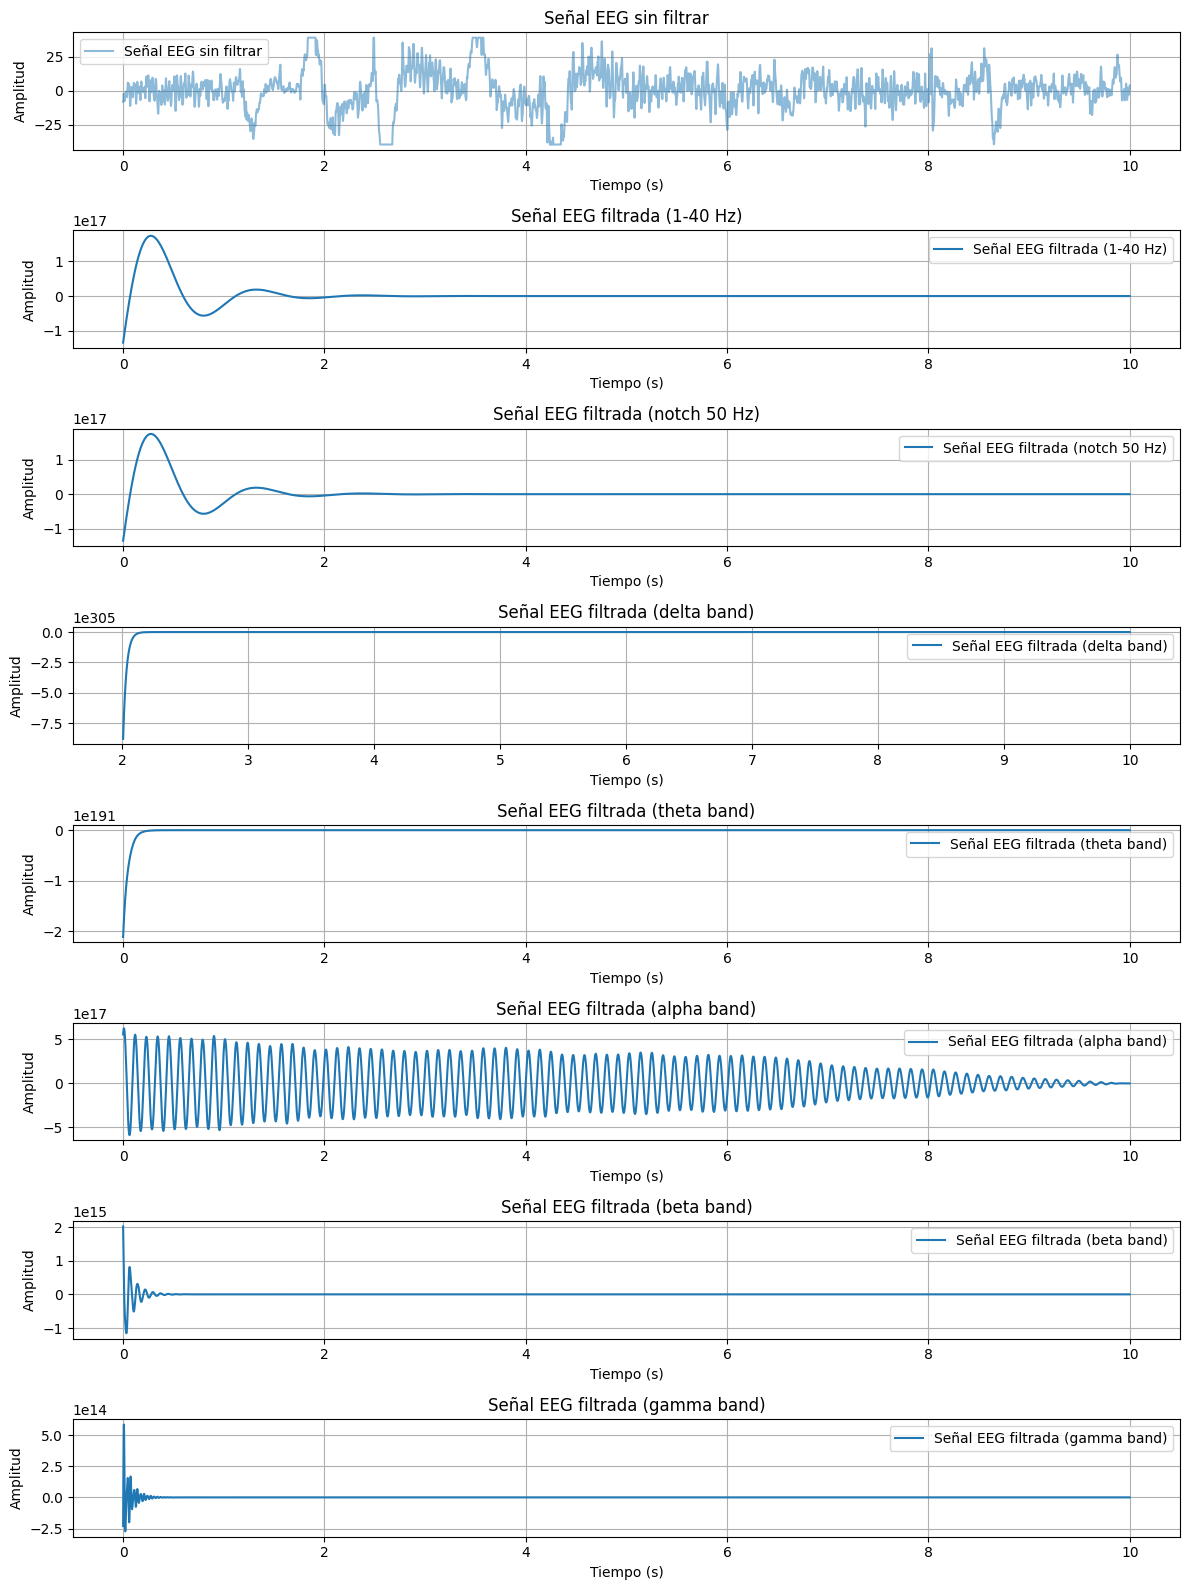

In [97]:
#Utilizamos un filtro IIR Para filtrar, estamos utilizando los valores encontrados en la literatura:
fs = 1000  # Frecuencia de muestreo
t = tiempo
eeg_data = valores

# Filtro pasa banda Butterworth de 1-40 Hz
lowcut = 1
highcut = 40
order = 5
b_bandpass, a_bandpass = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
eeg_bandpass_filtered = signal.filtfilt(b_bandpass, a_bandpass, eeg_data)

# Filtro rechaza banda (notch filter) de 50 Hz con un factor de calidad de 30
f0 = 50  # Frecuencia central del filtro notch
Q = 30   # Factor de calidad
b_notch, a_notch = signal.iirnotch(f0, Q, fs=fs)
eeg_notch_filtered = signal.filtfilt(b_notch, a_notch, eeg_bandpass_filtered)

# Subdivisión de EEG en bandas de frecuencia
bands = {'delta': (0.5, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 45)}

band_powers = {}

for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Calcular la potencia de la banda
    band_power = np.mean(eeg_band_filtered ** 2)
    band_powers[band] = band_power

# Imprimir las potencias de las bandas
print("Potencias de las bandas:")
for band, power in band_powers.items():
    print(f"{band}: {power}")

# Graficar cada señal filtrada y las bandas
plt.figure(figsize=(12, 16))

# Señal EEG sin filtrar
plt.subplot(len(bands) + 3, 1, 1)
plt.plot(t, eeg_data, label='Señal EEG sin filtrar', alpha=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG sin filtrar')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 3, 1, 2)
plt.plot(t, eeg_bandpass_filtered, label='Señal EEG filtrada (1-40 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (1-40 Hz)')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 3, 1, 3)
plt.plot(t, eeg_notch_filtered, label='Señal EEG filtrada (notch 50 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (notch 50 Hz)')
plt.legend()
plt.grid(True)

#Bandas
for i, (band, (low, high)) in enumerate(bands.items(), start=1):
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Graficar señal filtrada para la banda actual
    plt.subplot(len(bands) + 3, 1, i + 3)
    plt.plot(t, eeg_band_filtered, label=f'Señal EEG filtrada ({band} band)', linestyle='-')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Señal EEG filtrada ({band} band)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


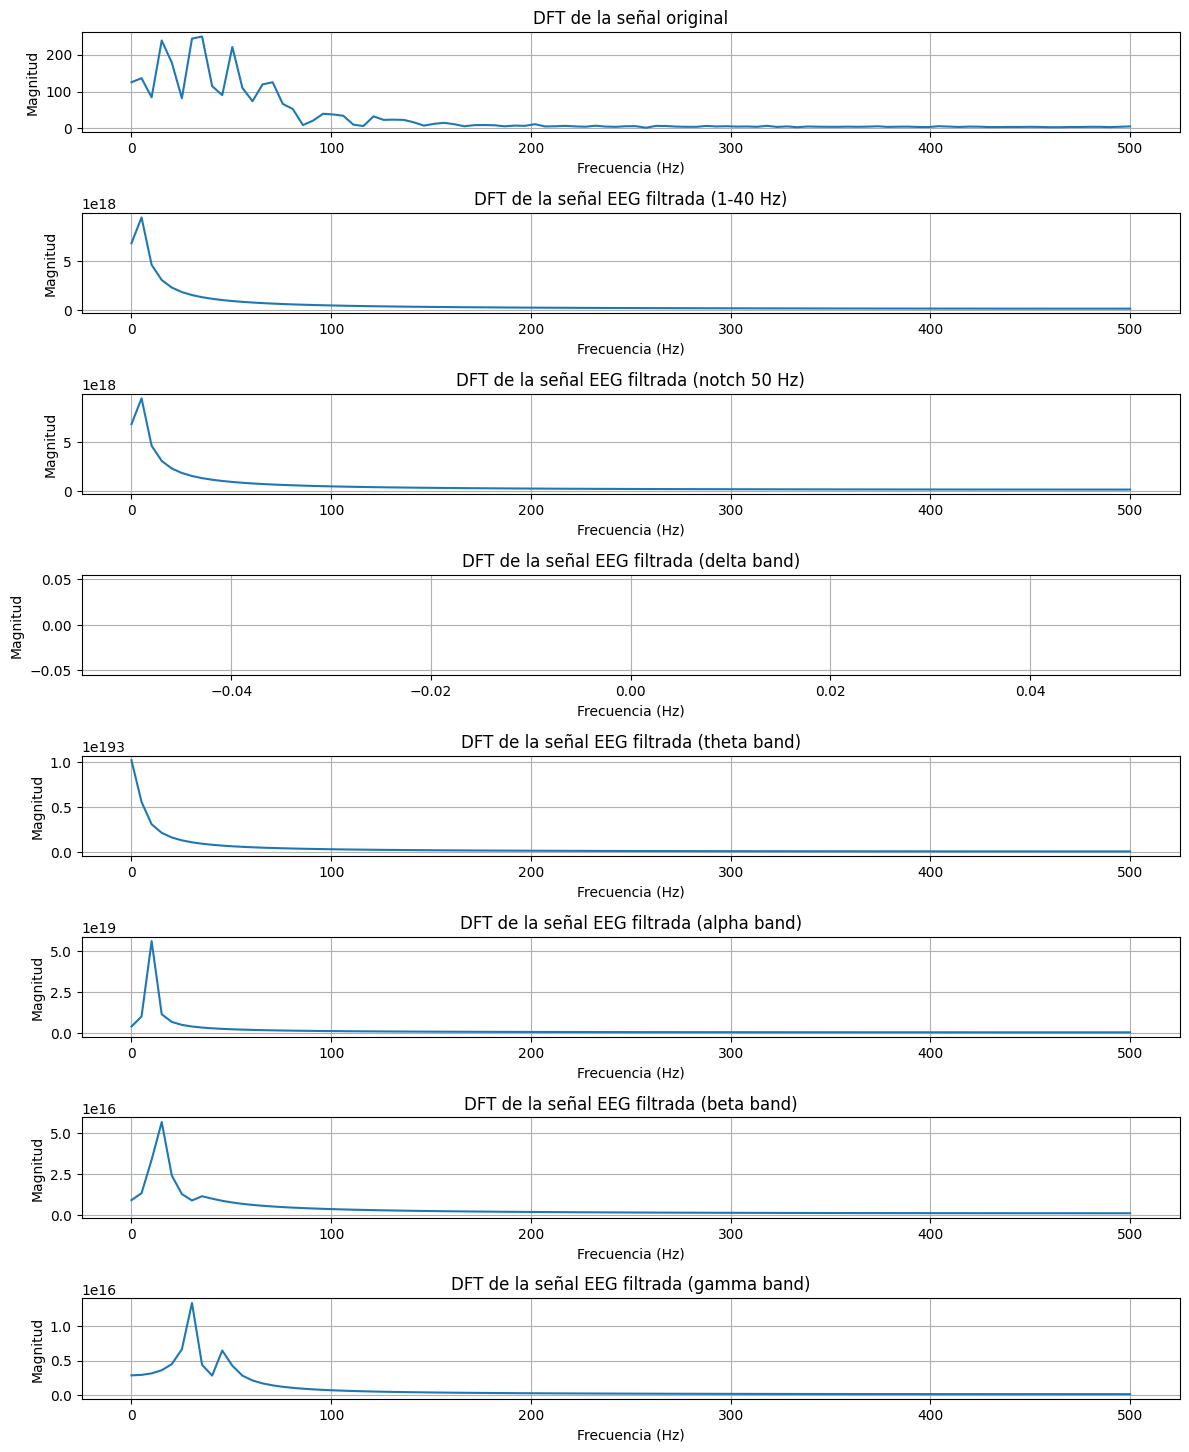

In [98]:
# Calcular la Transformada de Fourier Discreta (DFT) de la señal original
N = 200
X_original = np.fft.fft(valores, N)
X_original = X_original[:N//2]  # Considerar solo la mitad de la DFT (por simetría)
F_original = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (1-40 Hz)
X_bandpass = np.fft.fft(eeg_bandpass_filtered, N)
X_bandpass = X_bandpass[:N//2]
F_bandpass = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (notch 50 Hz)
X_notch = np.fft.fft(eeg_notch_filtered, N)
X_notch = X_notch[:N//2]
F_notch = np.linspace(0, fs/2, N//2)

# Calcular la DFT de las señales filtradas por banda
X_band_dfts = {}
for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Calcular la DFT de la señal filtrada
    X_band_dfts[band] = np.fft.fft(eeg_band_filtered, N)[:N//2]

# Graficar las DFT
plt.figure(figsize=(12, 16))

# Señal original
plt.subplot(len(bands) + 4, 1, 1)
plt.plot(F_original, np.abs(X_original))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal original')
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 4, 1, 2)
plt.plot(F_bandpass, np.abs(X_bandpass))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (1-40 Hz)')
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 4, 1, 3)
plt.plot(F_notch, np.abs(X_notch))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (notch 50 Hz)')
plt.grid(True)

# DFT de las señales filtradas por banda
for i, (band, X_band_dft) in enumerate(X_band_dfts.items(), start=1):
    plt.subplot(len(bands) + 4, 1, i + 3)
    plt.plot(F_bandpass, np.abs(X_band_dft))
    plt.ylabel('Magnitud')
    plt.xlabel('Frecuencia (Hz)')
    plt.title(f'DFT de la señal EEG filtrada ({band} band)')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Filtro FIR RESPUESTAS A PREGUNTAS MATEMÁTICAS



Potencias de las bandas:
delta: 5.4765029565715675e-05
theta: 0.00010224569343868257
alpha: 0.0004404726443183648
beta: 0.012134374141642102
gamma: 0.22424334741133403


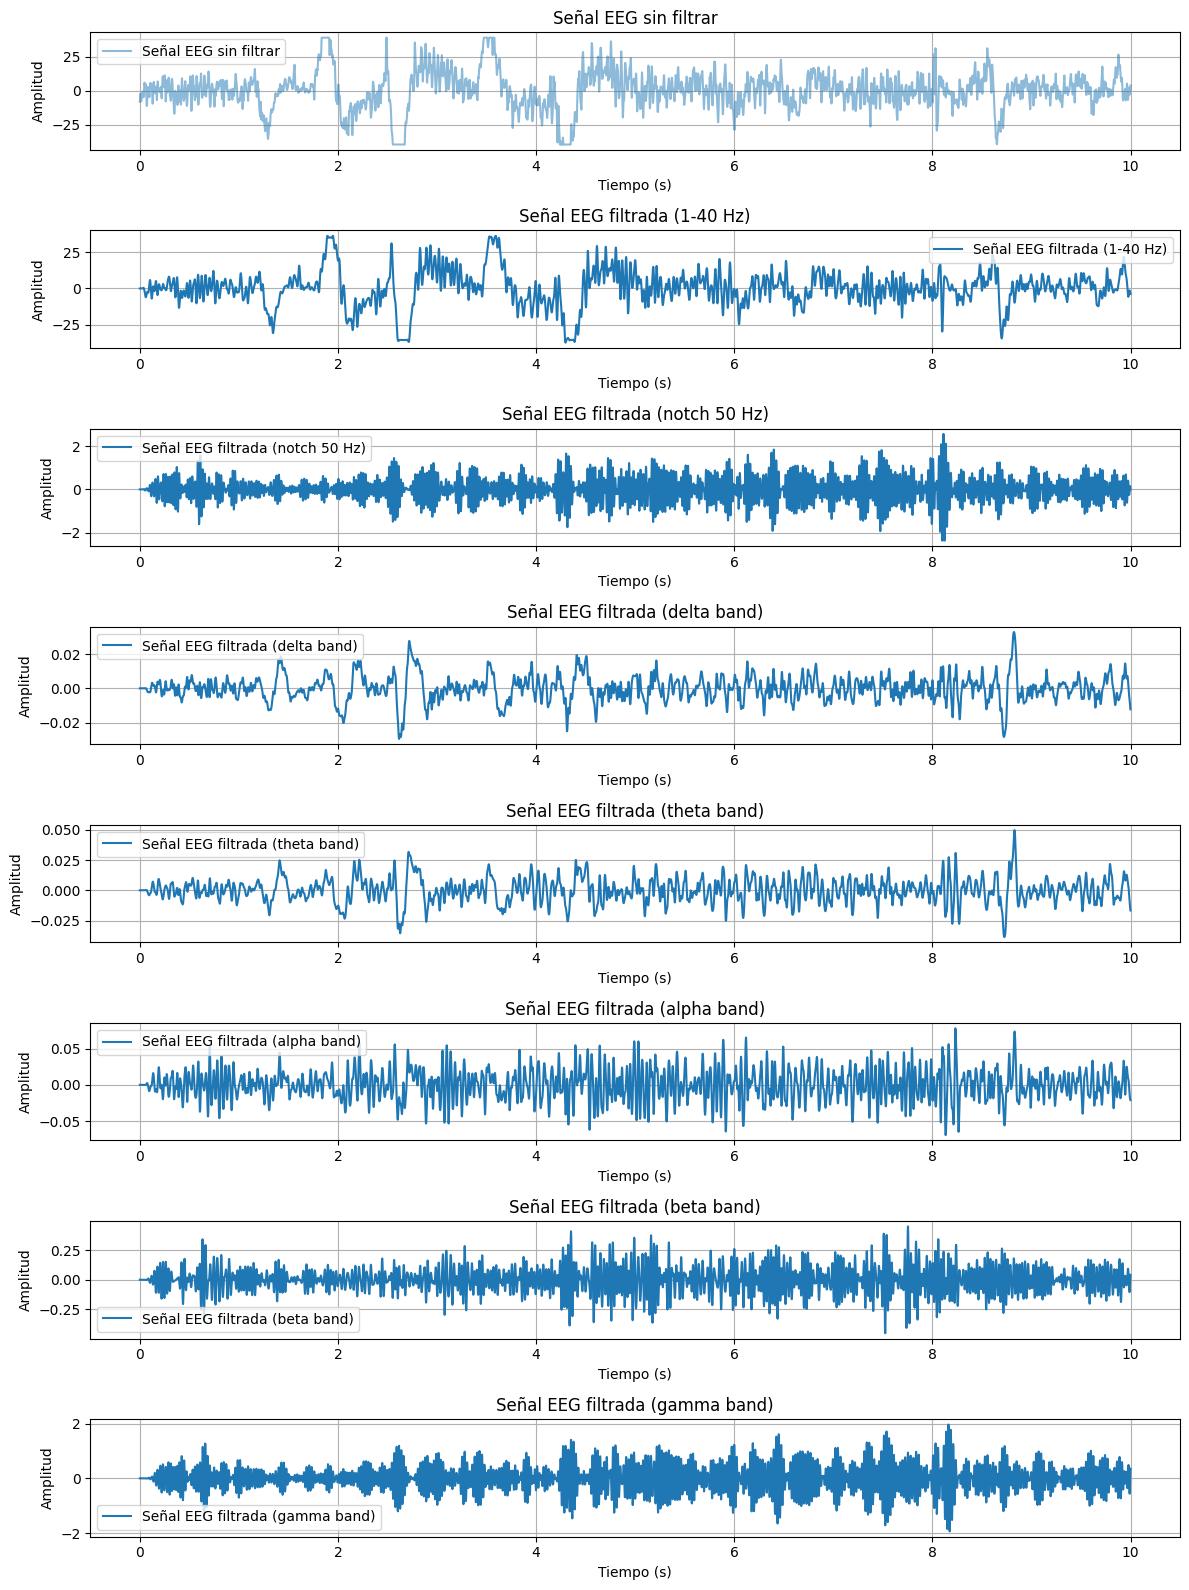

In [99]:
fs = 1000  # Frecuencia de muestreo
t = tiempo
eeg_data = valores

# Filtro pasa banda FIR de 1-40 Hz
lowcut = 1
highcut = 40
order = 100  # Longitud de la ventana FIR
b_bandpass = firwin(order + 1, [lowcut, highcut], fs=fs, pass_zero=False, window='hann')
eeg_bandpass_filtered = lfilter(b_bandpass, 1, eeg_data)

# Filtro rechaza banda FIR (notch filter) de 50 Hz
f0 = 50  # Frecuencia central del filtro notch
Q = 30   # Factor de calidad
b_notch = firwin(order + 1, [f0 - 1, f0 + 1], fs=fs, pass_zero=False, window='hann')
eeg_notch_filtered = lfilter(b_notch, 1, eeg_bandpass_filtered)

# Subdivisión de EEG en bandas de frecuencia
bands = {'delta': (0.5, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 45)}

band_powers = {}

for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda FIR para la banda actual
    b_band = firwin(order + 1, [low, high], fs=fs, pass_zero=False, window='hann')
    eeg_band_filtered = lfilter(b_band, 1, eeg_notch_filtered)

    # Calcular la potencia de la banda
    band_power = np.mean(eeg_band_filtered ** 2)
    band_powers[band] = band_power

# Imprimir las potencias de las bandas
print("Potencias de las bandas:")
for band, power in band_powers.items():
    print(f"{band}: {power}")

# Graficar cada señal filtrada y las bandas
plt.figure(figsize=(12, 16))

# Señal EEG sin filtrar
plt.subplot(len(bands) + 3, 1, 1)
plt.plot(t, eeg_data, label='Señal EEG sin filtrar', alpha=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG sin filtrar')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 3, 1, 2)
plt.plot(t, eeg_bandpass_filtered, label='Señal EEG filtrada (1-40 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (1-40 Hz)')
plt.legend()
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 3, 1, 3)
plt.plot(t, eeg_notch_filtered, label='Señal EEG filtrada (notch 50 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal EEG filtrada (notch 50 Hz)')
plt.legend()
plt.grid(True)

#Bandas
for i, (band, (low, high)) in enumerate(bands.items(), start=1):
    # Aplicar filtro pasa banda FIR para la banda actual
    b_band = firwin(order + 1, [low, high], fs=fs, pass_zero=False, window='hann')
    eeg_band_filtered = lfilter(b_band, 1, eeg_notch_filtered)

    # Graficar señal filtrada para la banda actual
    plt.subplot(len(bands) + 3, 1, i + 3)
    plt.plot(t, eeg_band_filtered, label=f'Señal EEG filtrada ({band} band)', linestyle='-')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Señal EEG filtrada ({band} band)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


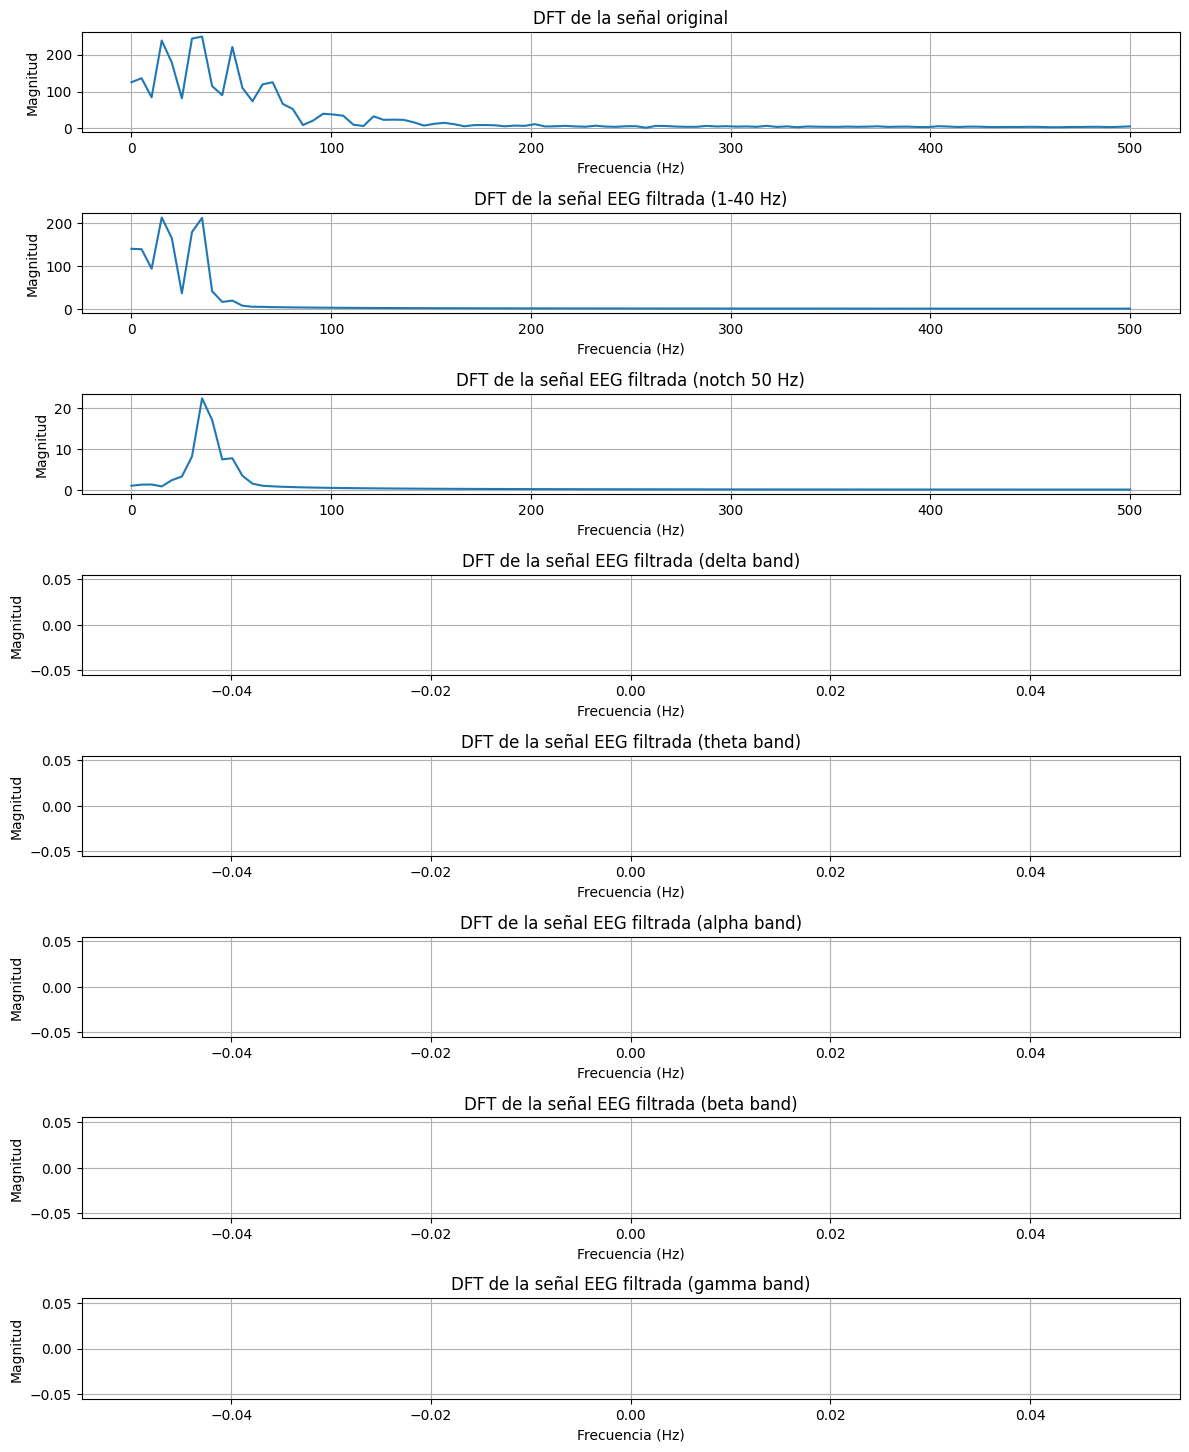

In [100]:
# Calcular la DFT de la señal original
N = 200
X_original = np.fft.fft(valores, N)
X_original = X_original[:N//2]  # Considerar solo la mitad de la DFT (por simetría)
F_original = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (1-40 Hz)
X_bandpass = np.fft.fft(eeg_bandpass_filtered, N)
X_bandpass = X_bandpass[:N//2]
F_bandpass = np.linspace(0, fs/2, N//2)

# Calcular la DFT de la señal filtrada (notch 50 Hz)
X_notch = np.fft.fft(eeg_notch_filtered, N)
X_notch = X_notch[:N//2]
F_notch = np.linspace(0, fs/2, N//2)

# Calcular la DFT de las señales filtradas por banda
X_band_dfts = {}
for band, (low, high) in bands.items():
    # Aplicar filtro pasa banda para la banda actual
    b_band, a_band = signal.butter(order, [low, high], btype='band', fs=fs)
    eeg_band_filtered = signal.filtfilt(b_band, a_band, eeg_notch_filtered)

    # Calcular la DFT de la señal filtrada
    X_band_dft = np.fft.fft(eeg_band_filtered, N)[:N//2]
    X_band_dfts[band] = X_band_dft

# Graficar las DFT
plt.figure(figsize=(12, 16))

# Señal original
plt.subplot(len(bands) + 4, 1, 1)
plt.plot(F_original, np.abs(X_original))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal original')
plt.grid(True)

# Señal EEG filtrada (1-40 Hz)
plt.subplot(len(bands) + 4, 1, 2)
plt.plot(F_original, np.abs(X_bandpass))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (1-40 Hz)')
plt.grid(True)

# Señal EEG filtrada (notch 50 Hz)
plt.subplot(len(bands) + 4, 1, 3)
plt.plot(F_original, np.abs(X_notch))
plt.ylabel('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.title('DFT de la señal EEG filtrada (notch 50 Hz)')
plt.grid(True)

# DFT de las señales filtradas por banda
for i, (band, X_band_dft) in enumerate(X_band_dfts.items(), start=1):
    plt.subplot(len(bands) + 4, 1, i + 3)
    plt.plot(F_original, np.abs(X_band_dft))
    plt.ylabel('Magnitud')
    plt.xlabel('Frecuencia (Hz)')
    plt.title(f'DFT de la señal EEG filtrada ({band} band)')
    plt.grid(True)

plt.tight_layout()
plt.show()